# SAE ANALYSIS

In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from src.data.dataloader import load_data
from src.models.clip_extractor import CLIPViTBaseExtractor
from src.models.sae_model import SparseAutoencoder

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

/opt/homebrew/anaconda3/envs/sae-clip/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Model and Data

In [5]:

test_data_loader = load_data(batch_size=32, subset_size=1000, split="valid")

feature_extractor = CLIPViTBaseExtractor().to(device)

sae = SparseAutoencoder(input_dim=768, expansion_factor=64).to(device)
saved_model_path = os.path.abspath('../sae_epoch_10.pth')
assert os.path.exists(saved_model_path)
sae.load_state_dict(torch.load(saved_model_path, map_location=device))


Generating valid split: 100%|██████████| 10000/10000 [00:00<00:00, 131585.60 examples/s]
/var/folders/94/217422514zd4vjkxjzd7ljt00000gn/T/ipykernel_81445/2351961377.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any iss

<All keys matched successfully>

### Evaluate Reconstruction

In [6]:
def evaluate_reconstruction_with_distribution(test_loader, sae, feature_extractor, device="mps"):
    sae.eval()
    mse_values = []

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Evaluating reconstruction")
        
        for batch in progress_bar:
            batch = batch.to(device)
            clip_features = feature_extractor(batch)
            _, reconstructed = sae(clip_features)
            
            # Compute reconstruction loss
            mse_loss = F.mse_loss(reconstructed, clip_features)
            mse_values.append(mse_loss.item())
            
            # Update progress bar with current mean loss
            progress_bar.set_postfix({'MSE': f'{np.mean(mse_values):.6f}'})

    # Convert to numpy array for easier analysis
    mse_values = np.array(mse_values)
    
    # Calculate statistics
    mean_mse = np.mean(mse_values)
    std_mse = np.std(mse_values)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.hist(mse_values, bins=30, density=True, alpha=0.7, color='blue')
    plt.axvline(mean_mse, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_mse:.6f}')
    
    # Add a normal distribution curve
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mean_mse, std_mse)
    plt.plot(x, p, 'k', linewidth=2, label='Normal dist. fit')
    
    plt.title('Distribution of Reconstruction MSE Values')
    plt.xlabel('MSE Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Print statistics
    print(f"\nMSE Statistics:")
    print(f"Mean: {mean_mse:.6f}")
    print(f"Std Dev: {std_mse:.6f}")
    print(f"Min: {np.min(mse_values):.6f}")
    print(f"Max: {np.max(mse_values):.6f}")
    
    plt.show()
    
    return mse_values

# Run the analysis
evaluate_reconstruction_with_distribution(test_data_loader, sae, feature_extractor)


Evaluating reconstruction:  22%|██▏       | 7/32 [00:26<01:34,  3.79s/it, MSE=0.000126]


KeyboardInterrupt: 

### Evaluate Sparsity

Evaluating sparsity: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it]


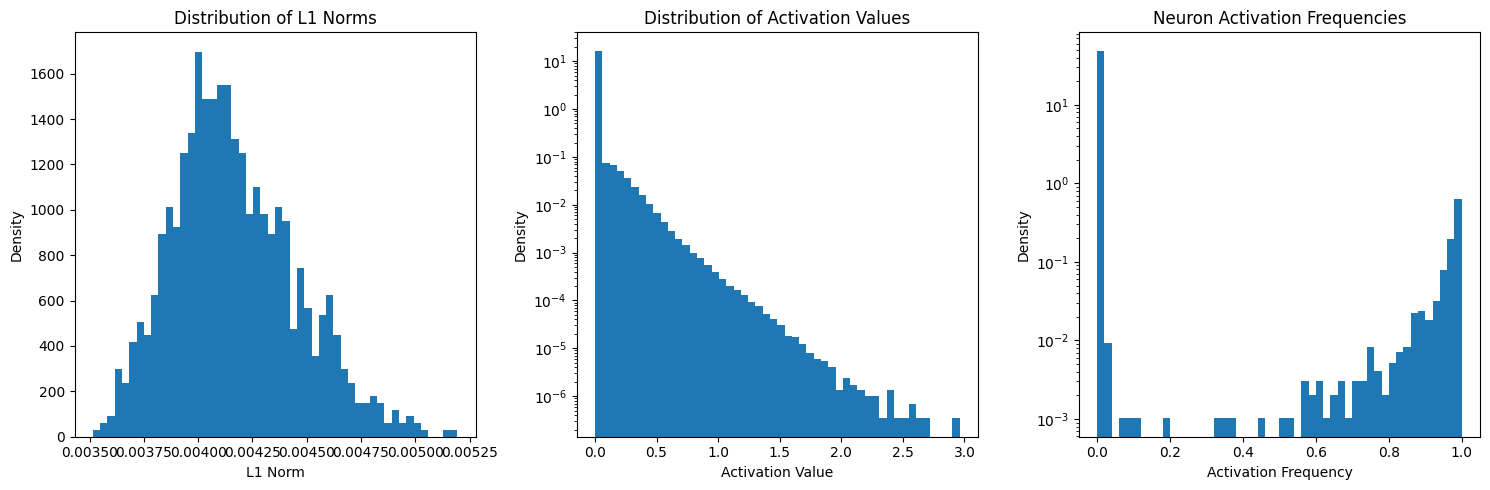


Sparsity Statistics:
Average L1 norm: 0.004167
Dead neurons: 48001/49152 (97.66%)
Mean activation frequency: 0.020627
Std activation frequency: 0.139539


In [7]:
def evaluate_sparsity(test_loader, sae, feature_extractor, device="mps"):
    """
    Evaluates different sparsity metrics of the SAE's encoded representations:
    1. Average activation (L1 norm)
    2. Fraction of dead neurons (never activate)
    3. Activation frequency per neuron
    4. Distribution of activations
    """
    sae.eval()
    all_activations = []
    
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Evaluating sparsity")
        
        for batch in progress_bar:
            batch = batch.to(device)
            clip_features = feature_extractor(batch)
            encoded, _ = sae(clip_features)
            all_activations.append(encoded.cpu())
    
    # Concatenate all activations
    all_activations = torch.cat(all_activations, dim=0)
    
    # 1. Average activation (L1 norm per sample)
    l1_norms = torch.mean(torch.abs(all_activations), dim=1)
    avg_l1 = torch.mean(l1_norms)
    
    # 2. Dead neurons (never activate)
    neuron_activations = torch.sum(all_activations > 0, dim=0)
    dead_neurons = torch.sum(neuron_activations == 0)
    total_neurons = all_activations.shape[1]
    dead_ratio = dead_neurons / total_neurons
    
    # 3. Activation frequency per neuron
    activation_frequencies = torch.mean((all_activations > 0).float(), dim=0)
    
    # Create visualizations
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Distribution of L1 norms
    plt.subplot(1, 3, 1)
    plt.hist(l1_norms.numpy(), bins=50, density=True)
    plt.title('Distribution of L1 Norms')
    plt.xlabel('L1 Norm')
    plt.ylabel('Density')
    
    # Plot 2: Distribution of activation values
    plt.subplot(1, 3, 2)
    plt.hist(all_activations.numpy().flatten(), bins=50, density=True)
    plt.title('Distribution of Activation Values')
    plt.yscale('log')
    plt.xlabel('Activation Value')
    plt.ylabel('Density')
    
    # Plot 3: Neuron activation frequencies
    plt.subplot(1, 3, 3)
    plt.hist(activation_frequencies.numpy(), bins=50, density=True)
    plt.title('Neuron Activation Frequencies')
    plt.yscale('log')
    plt.xlabel('Activation Frequency')
    plt.ylabel('Density')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nSparsity Statistics:")
    print(f"Average L1 norm: {avg_l1:.6f}")
    print(f"Dead neurons: {dead_neurons}/{total_neurons} ({dead_ratio*100:.2f}%)")
    print(f"Mean activation frequency: {torch.mean(activation_frequencies):.6f}")
    print(f"Std activation frequency: {torch.std(activation_frequencies):.6f}")
    
    return {
        'l1_norms': l1_norms,
        'activation_frequencies': activation_frequencies,
        'all_activations': all_activations,
        'dead_neurons': dead_neurons,
        'avg_l1': avg_l1
    }

sparsity_metrics = evaluate_sparsity(test_data_loader, sae, feature_extractor)